In [6]:
from datasets import load_dataset
import json
from tqdm import tqdm

# Load dataset in streaming mode
dataset = load_dataset("omegalabsinc/omega-multimodal", split="train", streaming=True)

# Number of samples to collect
num_samples = 50000
output_file = "omega_50k_samples.json"

# Stream and save data
with open(output_file, "w", encoding="utf-8") as f:
    for i, sample in tqdm(enumerate(dataset), total=num_samples, desc="Saving Dataset"):
        json.dump(sample, f)
        f.write("\n")  # New line for each JSON object
        if i >= num_samples - 1:
            break

print(f"Saved {num_samples} samples to {output_file}.")


KeyboardInterrupt: 

In [7]:
import json

# Path to saved dataset
dataset_path = "omega_50k_samples.json"

# Load and inspect dataset
def inspect_dataset_structure(file_path, num_samples=5):
    with open(file_path, "r", encoding="utf-8") as f:
        for i in range(num_samples):
            line = f.readline().strip()
            if not line:
                print(f"🔴 Empty line detected at entry {i+1}")
                continue
            try:
                sample = json.loads(line)
                print(f"\n🔹 **Sample {i+1} Field Types:**")
                for key, value in sample.items():
                    print(f"  - {key}: {type(value)}")
                print("\n" + "="*50 + "\n")
            except json.JSONDecodeError:
                print(f"🔴 JSON Decode Error in line {i+1}")

# Run preview function
inspect_dataset_structure(dataset_path)



🔹 **Sample 1 Field Types:**
  - video_id: <class 'str'>
  - youtube_id: <class 'str'>
  - description: <class 'str'>
  - views: <class 'int'>
  - start_time: <class 'int'>
  - end_time: <class 'int'>
  - video_embed: <class 'list'>
  - audio_embed: <class 'list'>
  - description_embed: <class 'list'>
  - description_relevance_score: <class 'float'>
  - query_relevance_score: <class 'float'>
  - query: <class 'str'>
  - submitted_at: <class 'int'>



🔹 **Sample 2 Field Types:**
  - video_id: <class 'str'>
  - youtube_id: <class 'str'>
  - description: <class 'str'>
  - views: <class 'int'>
  - start_time: <class 'int'>
  - end_time: <class 'int'>
  - video_embed: <class 'list'>
  - audio_embed: <class 'list'>
  - description_embed: <class 'list'>
  - description_relevance_score: <class 'float'>
  - query_relevance_score: <class 'float'>
  - query: <class 'str'>
  - submitted_at: <class 'int'>



🔹 **Sample 3 Field Types:**
  - video_id: <class 'str'>
  - youtube_id: <class 'str'>
  - d

In [8]:
import json

dataset_path = "omega_50k_samples.json"

def inspect_vector_sizes(file_path, num_samples=5):
    with open(file_path, "r", encoding="utf-8") as f:
        for i in range(num_samples):
            line = f.readline().strip()
            if not line:
                print(f"Empty line at sample {i+1}")
                continue
            try:
                sample = json.loads(line)
                video_size = len(sample.get("video_embed", []))
                description_size = len(sample.get("description_embed", []))
                audio_size = len(sample.get("audio_embed", []))
                print(f"Sample {i+1}:")
                print(f"  video_embed size: {video_size}")
                print(f"  description_embed size: {description_size}")
                print(f"  audio_embed size: {audio_size}")
                print("="*40)
            except json.JSONDecodeError:
                print(f"JSON Decode Error in sample {i+1}")

inspect_vector_sizes(dataset_path)


Sample 1:
  video_embed size: 1024
  description_embed size: 1024
  audio_embed size: 1024
Sample 2:
  video_embed size: 1024
  description_embed size: 1024
  audio_embed size: 1024
Sample 3:
  video_embed size: 1024
  description_embed size: 1024
  audio_embed size: 1024
Sample 4:
  video_embed size: 1024
  description_embed size: 1024
  audio_embed size: 1024
Sample 5:
  video_embed size: 1024
  description_embed size: 1024
  audio_embed size: 1024


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import json
from tqdm import tqdm

# Define MLP model for modality transformation
class MLPHead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=2028):
        super(MLPHead, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # Output stays in the embedding space
        )

    def forward(self, x):
        return self.model(x)

# Custom dataset class for loading preprocessed embeddings
class OmegaMultimodalDataset(Dataset):
    def __init__(self, file_path):
        self.data = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in tqdm(f, desc="Loading Dataset"):
                sample = json.loads(line)

                # Ensure all required fields are present
                if "audio_embed" in sample and "description_embed" in sample and "video_embed" in sample:
                    self.data.append({
                        "audio": torch.tensor(sample["audio_embed"], dtype=torch.float32),
                        "text": torch.tensor(sample["description_embed"], dtype=torch.float32),
                        "video": torch.tensor(sample["video_embed"], dtype=torch.float32),
                    })

        if len(self.data) == 0:
            raise ValueError("🔴 No valid samples found! Check JSON structure.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Detect MPS, CUDA, or fallback to CPU
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔹 Using device: {device}")

# Load dataset
dataset_path = "omega_50k_samples.json"
dataset = OmegaMultimodalDataset(dataset_path)

# Train-Test Split (80% Train, 20% Test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Determine embedding size
embedding_dim = len(dataset[0]["audio"])

# Initialize MLP heads for modality transformation (preserve embedding dimension)
audio_to_text = MLPHead(embedding_dim, embedding_dim).to(device)
text_to_video = MLPHead(embedding_dim, embedding_dim).to(device)
video_to_audio = MLPHead(embedding_dim, embedding_dim).to(device)

# Optimizers for each MLP
optimizer_a2t = optim.Adam(audio_to_text.parameters(), lr=1e-4)
optimizer_t2v = optim.Adam(text_to_video.parameters(), lr=1e-4)
optimizer_v2a = optim.Adam(video_to_audio.parameters(), lr=1e-4)

# Loss function (Cosine Similarity Loss)
criterion = nn.CosineEmbeddingLoss(margin=0.1)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    total_loss_a2t = 0
    total_loss_t2v = 0
    total_loss_v2a = 0

    # 🔹 Training Phase
    audio_to_text.train()
    text_to_video.train()
    video_to_audio.train()

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        # Move data to device
        audio_emb = batch["audio"].to(device)
        text_emb = batch["text"].to(device)
        video_emb = batch["video"].to(device)

        # Forward passes through MLPs
        pred_text = audio_to_text(audio_emb)  # Audio → Text
        pred_video = text_to_video(pred_text)  # Text → Video
        pred_audio = video_to_audio(pred_video)  # Video → Audio

        # Ensure labels match batch size for loss function
        batch_size = audio_emb.shape[0]
        positive_labels = torch.ones(batch_size, device=device)  # Ensure correct shape

        # Compute individual losses per MLP
        loss_a2t = criterion(pred_text, text_emb, positive_labels)  # Audio → Text Loss
        loss_t2v = criterion(pred_video, video_emb, positive_labels)  # Text → Video Loss
        loss_v2a = criterion(pred_audio, audio_emb, positive_labels)  # Video → Audio Loss

        # Zero gradients for each optimizer
        optimizer_a2t.zero_grad()
        optimizer_t2v.zero_grad()
        optimizer_v2a.zero_grad()

        # Backpropagate individual losses separately, retaining graph where needed
        loss_a2t.backward(retain_graph=True)
        loss_t2v.backward(retain_graph=True)
        loss_v2a.backward()  # Last backward call does not need retain_graph=True

        # Update parameters
        optimizer_a2t.step()
        optimizer_t2v.step()
        optimizer_v2a.step()

        # Accumulate loss
        total_loss_a2t += loss_a2t.item()
        total_loss_t2v += loss_t2v.item()
        total_loss_v2a += loss_v2a.item()

    # Compute average loss per epoch
    avg_loss_a2t = total_loss_a2t / len(train_dataloader)
    avg_loss_t2v = total_loss_t2v / len(train_dataloader)
    avg_loss_v2a = total_loss_v2a / len(train_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} [Train]")
    print(f"  🔹 Audio → Text Loss: {avg_loss_a2t:.4f}")
    print(f"  🔹 Text → Video Loss: {avg_loss_t2v:.4f}")
    print(f"  🔹 Video → Audio Loss: {avg_loss_v2a:.4f}")

    # 🔹 Evaluation Phase (on Test Set)
    audio_to_text.eval()
    text_to_video.eval()
    video_to_audio.eval()

    total_test_loss_a2t = 0
    total_test_loss_t2v = 0
    total_test_loss_v2a = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]"):
            # Move data to device
            audio_emb = batch["audio"].to(device)
            text_emb = batch["text"].to(device)
            video_emb = batch["video"].to(device)

            # Forward passes
            pred_text = audio_to_text(audio_emb)
            pred_video = text_to_video(pred_text)
            pred_audio = video_to_audio(pred_video)

            # Ensure labels match batch size for loss function
            batch_size = audio_emb.shape[0]
            positive_labels = torch.ones(batch_size, device=device)

            # Compute test losses
            loss_a2t = criterion(pred_text, text_emb, positive_labels)
            loss_t2v = criterion(pred_video, video_emb, positive_labels)
            loss_v2a = criterion(pred_audio, audio_emb, positive_labels)

            # Accumulate test loss
            total_test_loss_a2t += loss_a2t.item()
            total_test_loss_t2v += loss_t2v.item()
            total_test_loss_v2a += loss_v2a.item()

    avg_test_loss_a2t = total_test_loss_a2t / len(test_dataloader)
    avg_test_loss_t2v = total_test_loss_t2v / len(test_dataloader)
    avg_test_loss_v2a = total_test_loss_v2a / len(test_dataloader)

    print(f"Epoch {epoch+1}/{num_epochs} [Test]")
    print(f"  🔹 Audio → Text Test Loss: {avg_test_loss_a2t:.4f}")
    print(f"  🔹 Text → Video Test Loss: {avg_test_loss_t2v:.4f}")
    print(f"  🔹 Video → Audio Test Loss: {avg_test_loss_v2a:.4f}")

# Save trained models
torch.save(audio_to_text.state_dict(), "audio_to_text.pth")
torch.save(text_to_video.state_dict(), "text_to_video.pth")
torch.save(video_to_audio.state_dict(), "video_to_audio.pth")

print("✅ Models saved successfully.")


🔹 Using device: mps


Loading Dataset: 50000it [00:44, 1127.40it/s]
Epoch 1/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.35it/s]


Epoch 1/20 [Train]
  🔹 Audio → Text Loss: 0.4674
  🔹 Text → Video Loss: 0.4167
  🔹 Video → Audio Loss: 0.2606


Epoch 1/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 271.00it/s]


Epoch 1/20 [Test]
  🔹 Audio → Text Test Loss: 0.4581
  🔹 Text → Video Test Loss: 0.4039
  🔹 Video → Audio Test Loss: 0.1388


Epoch 2/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.69it/s]


Epoch 2/20 [Train]
  🔹 Audio → Text Loss: 0.4551
  🔹 Text → Video Loss: 0.4002
  🔹 Video → Audio Loss: 0.1151


Epoch 2/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 307.28it/s]


Epoch 2/20 [Test]
  🔹 Audio → Text Test Loss: 0.4558
  🔹 Text → Video Test Loss: 0.3996
  🔹 Video → Audio Test Loss: 0.0971


Epoch 3/20 [Train]: 100%|██████████| 625/625 [00:17<00:00, 35.97it/s]


Epoch 3/20 [Train]
  🔹 Audio → Text Loss: 0.4522
  🔹 Text → Video Loss: 0.3963
  🔹 Video → Audio Loss: 0.0865


Epoch 3/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 295.29it/s]


Epoch 3/20 [Test]
  🔹 Audio → Text Test Loss: 0.4549
  🔹 Text → Video Test Loss: 0.3976
  🔹 Video → Audio Test Loss: 0.0798


Epoch 4/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.18it/s]


Epoch 4/20 [Train]
  🔹 Audio → Text Loss: 0.4500
  🔹 Text → Video Loss: 0.3937
  🔹 Video → Audio Loss: 0.0721


Epoch 4/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 284.86it/s]


Epoch 4/20 [Test]
  🔹 Audio → Text Test Loss: 0.4541
  🔹 Text → Video Test Loss: 0.3962
  🔹 Video → Audio Test Loss: 0.0680


Epoch 5/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.82it/s]


Epoch 5/20 [Train]
  🔹 Audio → Text Loss: 0.4480
  🔹 Text → Video Loss: 0.3916
  🔹 Video → Audio Loss: 0.0637


Epoch 5/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 304.79it/s]


Epoch 5/20 [Test]
  🔹 Audio → Text Test Loss: 0.4540
  🔹 Text → Video Test Loss: 0.3955
  🔹 Video → Audio Test Loss: 0.0615


Epoch 6/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.44it/s]


Epoch 6/20 [Train]
  🔹 Audio → Text Loss: 0.4459
  🔹 Text → Video Loss: 0.3895
  🔹 Video → Audio Loss: 0.0581


Epoch 6/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 297.23it/s]


Epoch 6/20 [Test]
  🔹 Audio → Text Test Loss: 0.4540
  🔹 Text → Video Test Loss: 0.3947
  🔹 Video → Audio Test Loss: 0.0552


Epoch 7/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.05it/s]


Epoch 7/20 [Train]
  🔹 Audio → Text Loss: 0.4436
  🔹 Text → Video Loss: 0.3872
  🔹 Video → Audio Loss: 0.0539


Epoch 7/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 303.03it/s]


Epoch 7/20 [Test]
  🔹 Audio → Text Test Loss: 0.4543
  🔹 Text → Video Test Loss: 0.3951
  🔹 Video → Audio Test Loss: 0.0551


Epoch 8/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.72it/s]


Epoch 8/20 [Train]
  🔹 Audio → Text Loss: 0.4411
  🔹 Text → Video Loss: 0.3849
  🔹 Video → Audio Loss: 0.0514


Epoch 8/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 300.40it/s]


Epoch 8/20 [Test]
  🔹 Audio → Text Test Loss: 0.4549
  🔹 Text → Video Test Loss: 0.3943
  🔹 Video → Audio Test Loss: 0.0516


Epoch 9/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.43it/s]


Epoch 9/20 [Train]
  🔹 Audio → Text Loss: 0.4381
  🔹 Text → Video Loss: 0.3822
  🔹 Video → Audio Loss: 0.0488


Epoch 9/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 301.40it/s]


Epoch 9/20 [Test]
  🔹 Audio → Text Test Loss: 0.4557
  🔹 Text → Video Test Loss: 0.3947
  🔹 Video → Audio Test Loss: 0.0493


Epoch 10/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.12it/s]


Epoch 10/20 [Train]
  🔹 Audio → Text Loss: 0.4347
  🔹 Text → Video Loss: 0.3789
  🔹 Video → Audio Loss: 0.0476


Epoch 10/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 300.97it/s]


Epoch 10/20 [Test]
  🔹 Audio → Text Test Loss: 0.4566
  🔹 Text → Video Test Loss: 0.3948
  🔹 Video → Audio Test Loss: 0.0482


Epoch 11/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.25it/s]


Epoch 11/20 [Train]
  🔹 Audio → Text Loss: 0.4309
  🔹 Text → Video Loss: 0.3753
  🔹 Video → Audio Loss: 0.0462


Epoch 11/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 300.81it/s]


Epoch 11/20 [Test]
  🔹 Audio → Text Test Loss: 0.4576
  🔹 Text → Video Test Loss: 0.3964
  🔹 Video → Audio Test Loss: 0.0464


Epoch 12/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.70it/s]


Epoch 12/20 [Train]
  🔹 Audio → Text Loss: 0.4265
  🔹 Text → Video Loss: 0.3711
  🔹 Video → Audio Loss: 0.0457


Epoch 12/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 284.30it/s]


Epoch 12/20 [Test]
  🔹 Audio → Text Test Loss: 0.4601
  🔹 Text → Video Test Loss: 0.3973
  🔹 Video → Audio Test Loss: 0.0469


Epoch 13/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.32it/s]


Epoch 13/20 [Train]
  🔹 Audio → Text Loss: 0.4217
  🔹 Text → Video Loss: 0.3667
  🔹 Video → Audio Loss: 0.0450


Epoch 13/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 302.51it/s]


Epoch 13/20 [Test]
  🔹 Audio → Text Test Loss: 0.4619
  🔹 Text → Video Test Loss: 0.3980
  🔹 Video → Audio Test Loss: 0.0466


Epoch 14/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.95it/s]


Epoch 14/20 [Train]
  🔹 Audio → Text Loss: 0.4165
  🔹 Text → Video Loss: 0.3616
  🔹 Video → Audio Loss: 0.0446


Epoch 14/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 290.20it/s]


Epoch 14/20 [Test]
  🔹 Audio → Text Test Loss: 0.4660
  🔹 Text → Video Test Loss: 0.4009
  🔹 Video → Audio Test Loss: 0.0473


Epoch 15/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.59it/s]


Epoch 15/20 [Train]
  🔹 Audio → Text Loss: 0.4112
  🔹 Text → Video Loss: 0.3564
  🔹 Video → Audio Loss: 0.0443


Epoch 15/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 299.39it/s]


Epoch 15/20 [Test]
  🔹 Audio → Text Test Loss: 0.4675
  🔹 Text → Video Test Loss: 0.4004
  🔹 Video → Audio Test Loss: 0.0466


Epoch 16/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.17it/s]


Epoch 16/20 [Train]
  🔹 Audio → Text Loss: 0.4056
  🔹 Text → Video Loss: 0.3509
  🔹 Video → Audio Loss: 0.0440


Epoch 16/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 299.10it/s]


Epoch 16/20 [Test]
  🔹 Audio → Text Test Loss: 0.4699
  🔹 Text → Video Test Loss: 0.4021
  🔹 Video → Audio Test Loss: 0.0460


Epoch 17/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.09it/s]


Epoch 17/20 [Train]
  🔹 Audio → Text Loss: 0.3998
  🔹 Text → Video Loss: 0.3453
  🔹 Video → Audio Loss: 0.0441


Epoch 17/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 300.06it/s]


Epoch 17/20 [Test]
  🔹 Audio → Text Test Loss: 0.4727
  🔹 Text → Video Test Loss: 0.4060
  🔹 Video → Audio Test Loss: 0.0462


Epoch 18/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 37.63it/s]


Epoch 18/20 [Train]
  🔹 Audio → Text Loss: 0.3941
  🔹 Text → Video Loss: 0.3397
  🔹 Video → Audio Loss: 0.0438


Epoch 18/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 297.16it/s]


Epoch 18/20 [Test]
  🔹 Audio → Text Test Loss: 0.4759
  🔹 Text → Video Test Loss: 0.4092
  🔹 Video → Audio Test Loss: 0.0458


Epoch 19/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.02it/s]


Epoch 19/20 [Train]
  🔹 Audio → Text Loss: 0.3882
  🔹 Text → Video Loss: 0.3340
  🔹 Video → Audio Loss: 0.0438


Epoch 19/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 300.14it/s]


Epoch 19/20 [Test]
  🔹 Audio → Text Test Loss: 0.4791
  🔹 Text → Video Test Loss: 0.4080
  🔹 Video → Audio Test Loss: 0.0466


Epoch 20/20 [Train]: 100%|██████████| 625/625 [00:16<00:00, 38.08it/s]


Epoch 20/20 [Train]
  🔹 Audio → Text Loss: 0.3822
  🔹 Text → Video Loss: 0.3286
  🔹 Video → Audio Loss: 0.0435


Epoch 20/20 [Test]: 100%|██████████| 157/157 [00:00<00:00, 279.76it/s]


Epoch 20/20 [Test]
  🔹 Audio → Text Test Loss: 0.4826
  🔹 Text → Video Test Loss: 0.4121
  🔹 Video → Audio Test Loss: 0.0465
✅ Models saved successfully.


In [15]:
import umap.umap_ as umap
print(umap.UMAP())
import matplotlib
print(matplotlib.__version__)  # Check if it's installed properly


UMAP()
3.10.1


/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


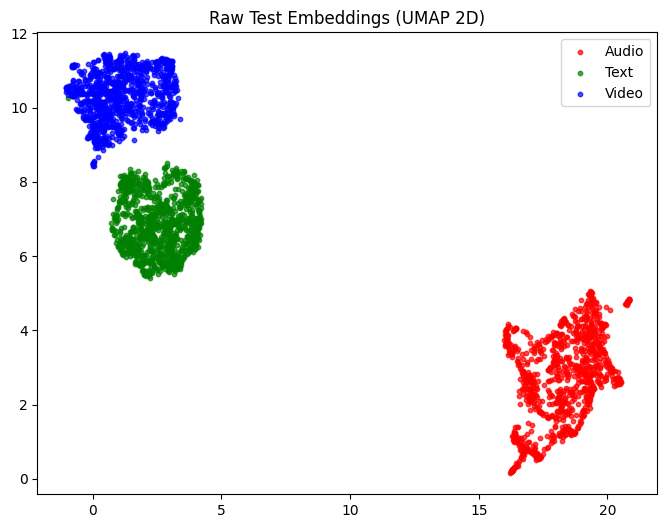

/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


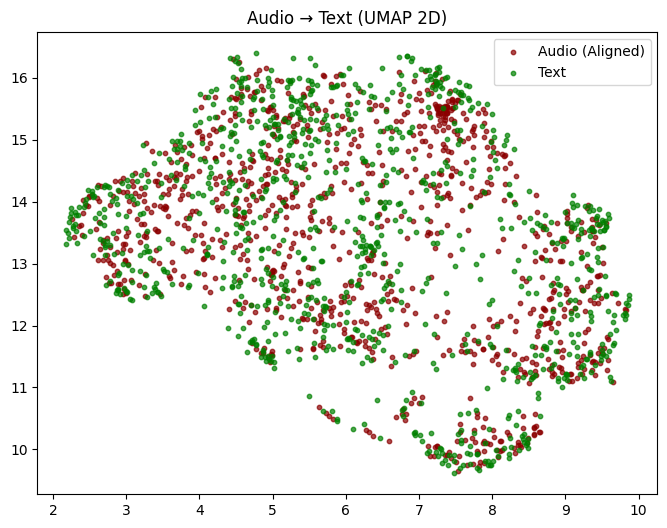

/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


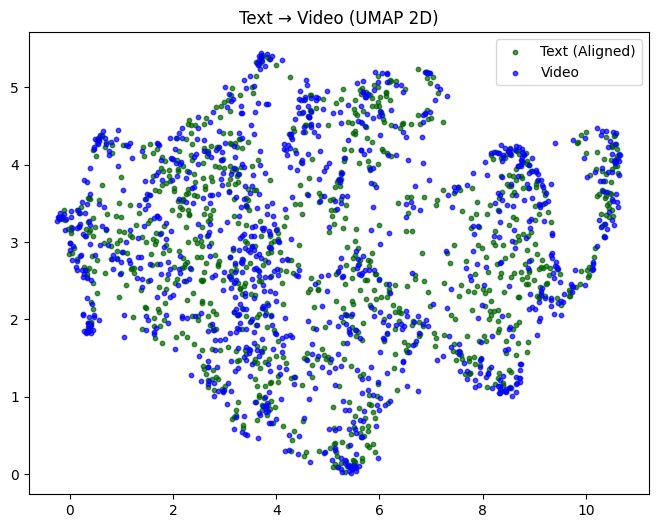

/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/yannbaglinbunod/miniconda3/envs/eor/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


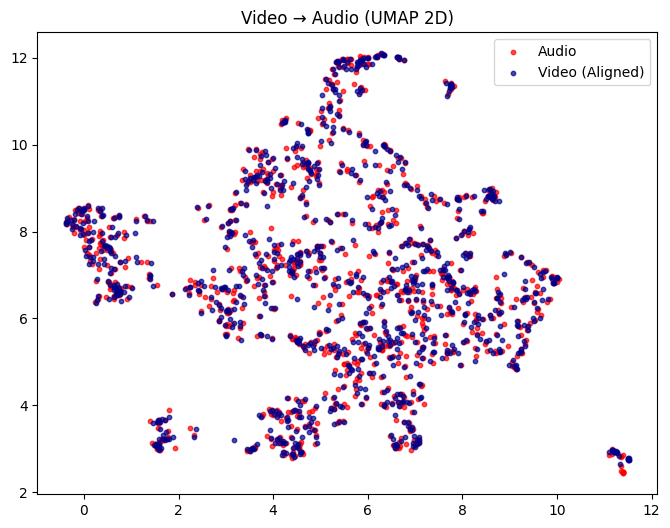

In [20]:
# ------------------------------
# 🔹 UMAP Visualization of Test Data Before and After Transformation
# ------------------------------
import umap.umap_ as umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

def plot_umap(raw_data, aligned_data, raw_labels, aligned_labels, title, filename=None):
    """ UMAP 2D visualization of embeddings with raw & aligned data """
    umap_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
    
    # Concatenate raw & aligned data for joint UMAP transformation
    all_data = np.vstack([raw_data, aligned_data])
    embedded_2d = umap_2d.fit_transform(all_data)
    
    # Extract separated embeddings
    raw_2d = embedded_2d[:len(raw_data)]
    aligned_2d = embedded_2d[len(raw_data):]

    # Generate color mapping dynamically
    unique_labels = np.unique(np.concatenate([raw_labels, aligned_labels]))
    palette = sns.color_palette("husl", len(unique_labels))
    colors = dict(zip(unique_labels, palette))

    plt.figure(figsize=(8, 6))

    # Plot raw embeddings (fainter colors)
    for mod in np.unique(raw_labels):
        idx = (raw_labels == mod)
        plt.scatter(raw_2d[idx, 0], raw_2d[idx, 1], s=10, color=colors[mod], label=f"{mod} (Raw)", alpha=0.3)

    # Plot aligned embeddings (stronger colors)
    for mod in np.unique(aligned_labels):
        idx = (aligned_labels == mod)
        plt.scatter(aligned_2d[idx, 0], aligned_2d[idx, 1], s=15, color=colors[mod], label=f"{mod} (Aligned)", alpha=0.9)

    plt.title(title)
    plt.legend()

    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()


# Load test data
test_size = 1000  # Adjust as needed
test_loader = DataLoader(test_dataset, batch_size=test_size, shuffle=False)

with torch.no_grad():
    for batch in test_loader:
        audio_embed = batch["audio"].to(device).cpu().numpy()
        text_embed = batch["text"].to(device).cpu().numpy()
        video_embed = batch["video"].to(device).cpu().numpy()

        # Apply transformations
        audio_to_text_embed = audio_to_text(torch.tensor(audio_embed).to(device)).cpu().numpy()
        text_to_video_embed = text_to_video(torch.tensor(audio_to_text_embed).to(device)).cpu().numpy()
        video_to_audio_embed = video_to_audio(torch.tensor(text_to_video_embed).to(device)).cpu().numpy()
        break  # Only take first batch


# 1️⃣ **Raw Test Embeddings**
raw_embeddings = np.vstack([audio_embed, text_embed, video_embed])
raw_labels = np.array(['Audio'] * len(audio_embed) + ['Text'] * len(text_embed) + ['Video'] * len(video_embed))
plot_umap(raw_embeddings, raw_embeddings, raw_labels, raw_labels, "Raw Test Embeddings (UMAP 2D)", "raw_test_embeddings.png")

# 2️⃣ **Audio → Text Alignment**
aligned_labels = np.array(['Audio (Aligned)'] * len(audio_to_text_embed) + ['Text'] * len(text_embed))
plot_umap(raw_embeddings, np.vstack([audio_to_text_embed, text_embed]), raw_labels, aligned_labels, "Audio → Text (UMAP 2D)", "audio_to_text.png")

# 3️⃣ **Text → Video Alignment**
aligned_labels = np.array(['Text (Aligned)'] * len(text_to_video_embed) + ['Video'] * len(video_embed))
plot_umap(raw_embeddings, np.vstack([text_to_video_embed, video_embed]), raw_labels, aligned_labels, "Text → Video (UMAP 2D)", "text_to_video.png")

# 4️⃣ **Video → Audio Alignment**
aligned_labels = np.array(['Video (Aligned)'] * len(video_to_audio_embed) + ['Audio'] * len(audio_embed))
plot_umap(raw_embeddings, np.vstack([video_to_audio_embed, audio_embed]), raw_labels, aligned_labels, "Video → Audio (UMAP 2D)", "video_to_audio.png")


In [ ]:
from sklearn.manifold import TSNE

# 2D t-SNE projection for raw and aligned embeddings
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
raw_tsne_2d = tsne.fit_transform(raw_embeddings)      # :contentReference[oaicite:4]{index=4}
aligned_tsne_2d = tsne.fit_transform(aligned_embeddings)

# Plot side-by-side 2D t-SNE scatterplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, data, title in zip(axes, [raw_tsne_2d, aligned_tsne_2d], ['Raw Embeddings (t-SNE 2D)', 'Aligned Embeddings (t-SNE 2D)']):
    for mod in modalities:
        idx = (labels == mod)
        ax.scatter(data[idx, 0], data[idx, 1], s=10, color=colors[mod], label=mod, alpha=0.7)
    ax.set_title(title)
    ax.legend()
plt.tight_layout()
plt.show()

# (Optional) For 3D t-SNE, set n_components=3 in TSNE() and use a 3D scatter plot as done for UMAP.


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(data, labels, title, colors, filename=None, dim=2):
    """ t-SNE visualization of embeddings """
    tsne = TSNE(n_components=dim, perplexity=30, init='pca', random_state=42)
    embedded = tsne.fit_transform(data)

    if dim == 2:
        plt.figure(figsize=(8, 6))
        for mod in np.unique(labels):
            idx = (labels == mod)
            plt.scatter(embedded[idx, 0], embedded[idx, 1], s=10, color=colors[mod], label=mod, alpha=0.7)
        plt.title(title)
        plt.legend()
        
    elif dim == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        for mod in np.unique(labels):
            idx = (labels == mod)
            ax.scatter(embedded[idx, 0], embedded[idx, 1], embedded[idx, 2], s=10, color=colors[mod], label=mod, alpha=0.7)
        ax.set_title(title)
        ax.legend()

    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Define colors
colors = {'Audio': 'red', 'Text': 'green', 'Video': 'blue'}

# 1️⃣ Raw Test Embeddings (2D t-SNE)
raw_embeddings = np.vstack([audio_embed, text_embed, video_embed])
raw_labels = np.array(['Audio'] * len(audio_embed) + ['Text'] * len(text_embed) + ['Video'] * len(video_embed))
plot_tsne(raw_embeddings, raw_labels, "Raw Test Embeddings (t-SNE 2D)", colors, "raw_test_tsne.png", dim=2)

# 2️⃣ Audio → Text Alignment (2D t-SNE)
audio_text_embeddings = np.vstack([audio_to_text_embed, text_embed])
audio_text_labels = np.array(['Audio (Aligned)'] * len(audio_to_text_embed) + ['Text'] * len(text_embed))
plot_tsne(audio_text_embeddings, audio_text_labels, "Audio → Text (t-SNE 2D)", colors, "audio_to_text_tsne.png", dim=2)

# 3️⃣ Text → Video Alignment (2D t-SNE)
text_video_embeddings = np.vstack([text_to_video_embed, video_embed])
text_video_labels = np.array(['Text (Aligned)'] * len(text_to_video_embed) + ['Video'] * len(video_embed))
plot_tsne(text_video_embeddings, text_video_labels, "Text → Video (t-SNE 2D)", colors, "text_to_video_tsne.png", dim=2)

# 4️⃣ Video → Audio Alignment (2D t-SNE)
video_audio_embeddings = np.vstack([video_to_audio_embed, audio_embed])
video_audio_labels = np.array(['Video (Aligned)'] * len(video_to_audio_embed) + ['Audio'] * len(audio_embed))
plot_tsne(video_audio_embeddings, video_audio_labels, "Video → Audio (t-SNE 2D)", colors, "video_to_audio_tsne.png", dim=2)

# (Optional) 3D t-SNE
plot_tsne(raw_embeddings, raw_labels, "Raw Test Embeddings (t-SNE 3D)", colors, "raw_test_tsne_3d.png", dim=3)
plot_tsne(audio_text_embeddings, audio_text_labels, "Audio → Text (t-SNE 3D)", colors, "audio_to_text_tsne_3d.png", dim=3)
plot_tsne(text_video_embeddings, text_video_labels, "Text → Video (t-SNE 3D)", colors, "text_to_video_tsne_3d.png", dim=3)
plot_tsne(video_audio_embeddings, video_audio_labels, "Video → Audio (t-SNE 3D)", colors, "video_to_audio_tsne_3d.png", dim=3)
